In [1]:
%pip install tensorflow seaborn


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers




[notice] A new release of pip available: 22.2.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


load dataset

In [3]:
# Load Pima Indian Diabetes dataset
df = pd.read_csv("F:/RUSL/4- 1/ICT 4302 - Intelligent Systems/miniProject1/diabetes.csv")

df.columns = df.columns.str.strip()  # Clean header spaces
for col in df.columns:
    if col != 'Outcome':
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert non-numeric to NaN

numeric_df = df.select_dtypes(include=['number'])

df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Data preprocessing

step 1 - Replace invalid zeros with NaN (handle missing values)

In [4]:
cols_with_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace 0 with np.nan only for these features
df[cols_with_missing] = df[cols_with_missing].replace(0, np.nan)


In [5]:
# Remove rows with too many missing values
def drop_rows_with_many_missing(df, threshold_cols=4):
    return df[df[cols_with_missing].isnull().sum(axis=1) < threshold_cols]

df = drop_rows_with_many_missing(df)

In [6]:
# Define columns for different strategies
median_columns = ["Glucose", "BloodPressure"]
knn_columns = ["SkinThickness", "Insulin", "BMI"]

step 2 - fill missing values using the median of the same class

In [7]:
# Apply same-class median imputation
def impute_same_class_median(df, columns, class_col="Outcome"):
    for col in columns:
        df[col] = df.groupby(class_col)[col].transform(lambda x: x.fillna(x.median()))
    return df

df = impute_same_class_median(df, median_columns)

In [8]:
# Apply KNN Imputer for selected columns
def knn_impute(df, columns, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df[columns] = imputer.fit_transform(df[columns])
    return df

df = knn_impute(df, knn_columns)

In [9]:
# Normalize features (optional but recommended)
from sklearn.preprocessing import MinMaxScaler


features = df.columns[:-1]  # Exclude Outcome
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [10]:
print("✅ Cleaned dataset ready for model:")
display(df.head())

✅ Cleaned dataset ready for model:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,0.213221,0.314928,0.234415,0.483333,1
1,0.058824,0.264516,0.428571,0.239130,0.128125,0.171779,0.116567,0.166667,0
2,0.470588,0.896774,0.408163,0.106522,0.106010,0.104294,0.253629,0.183333,1
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000,0
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000,1


In [11]:
# Step 1: Split features and labels
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Step 2: Apply SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)




data split

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1)


build custom keras model

In [13]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
#add extra hidden layer and change number of nodes in each layer

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


Train the model

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=2) #change validation split from 0.2-> 0.1


Epoch 1/100
45/45 - 9s - loss: 0.6735 - accuracy: 0.5668 - val_loss: 0.6570 - val_accuracy: 0.5674 - 9s/epoch - 194ms/step
Epoch 2/100
45/45 - 2s - loss: 0.6447 - accuracy: 0.6371 - val_loss: 0.6308 - val_accuracy: 0.6292 - 2s/epoch - 51ms/step
Epoch 3/100
45/45 - 2s - loss: 0.6060 - accuracy: 0.7145 - val_loss: 0.5932 - val_accuracy: 0.7360 - 2s/epoch - 36ms/step
Epoch 4/100
45/45 - 2s - loss: 0.5715 - accuracy: 0.7257 - val_loss: 0.5657 - val_accuracy: 0.7640 - 2s/epoch - 42ms/step
Epoch 5/100
45/45 - 1s - loss: 0.5574 - accuracy: 0.7398 - val_loss: 0.5447 - val_accuracy: 0.7753 - 1s/epoch - 25ms/step
Epoch 6/100
45/45 - 1s - loss: 0.5339 - accuracy: 0.7370 - val_loss: 0.5889 - val_accuracy: 0.6685 - 1s/epoch - 23ms/step
Epoch 7/100
45/45 - 2s - loss: 0.5230 - accuracy: 0.7567 - val_loss: 0.5203 - val_accuracy: 0.7472 - 2s/epoch - 47ms/step
Epoch 8/100
45/45 - 1s - loss: 0.5104 - accuracy: 0.7553 - val_loss: 0.5111 - val_accuracy: 0.7528 - 1s/epoch - 26ms/step
Epoch 9/100
45/45 - 1s 

Evaluate the model

4/4 [==============================] - 0s 8ms/step
✅ Test Accuracy: 0.86

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.85      0.87        54
           1       0.83      0.87      0.85        45

    accuracy                           0.86        99
   macro avg       0.86      0.86      0.86        99
weighted avg       0.86      0.86      0.86        99



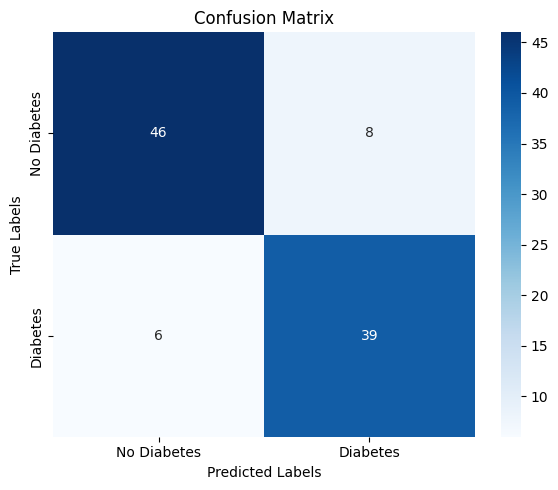

Accuracy: 0.8585858585858586
Precision: 0.8297872340425532
Recall: 0.8666666666666667
F1 Score: 0.8478260869565217


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

# Predict probabilities
y_pred_prob = model.predict(X_test).ravel()

# Convert to binary output
y_pred = (y_pred_prob >= 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Test Accuracy: {test_accuracy:.2f}")

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['No Diabetes', 'Diabetes']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


# Individual metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


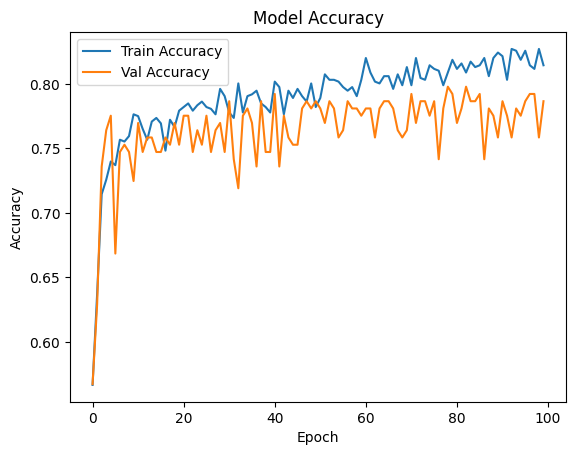

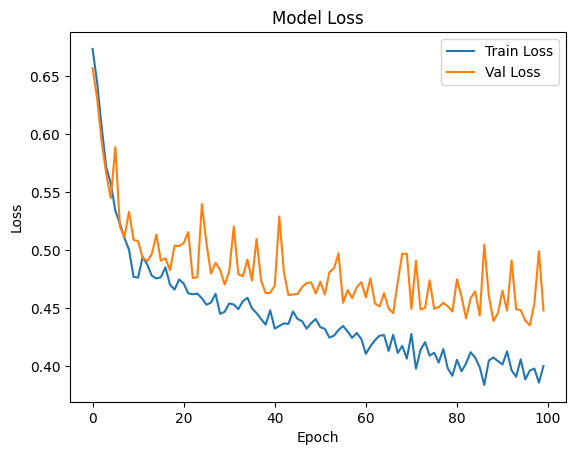

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


4/4 [==============================] - 0s 7ms/step


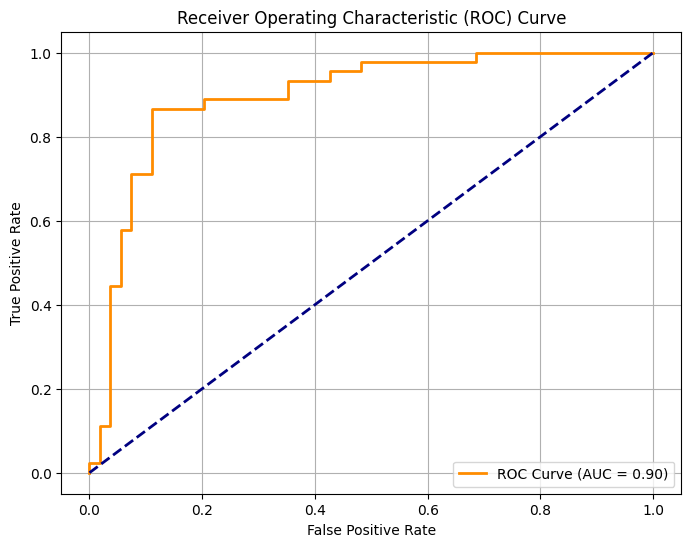

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities for the test set
y_pred_prob = model.predict(X_test).ravel()  # Already flattened

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
